In [466]:
import sys
sys.path.append("../../../")

import yfinance as yf
import pandas as pd
import numpy as np
import torch as tc
import matplotlib.pyplot as plt

from scipy.signal import detrend
from scipy.optimize import minimize

from tqdm import tqdm

from rcgp.rcgp import SpatioTemporalRCGP

[*********************100%***********************]  6 of 6 completed


torch.Size([250, 1]) torch.Size([6, 2]) torch.Size([250, 6, 1])


<Axes: xlabel='Date'>

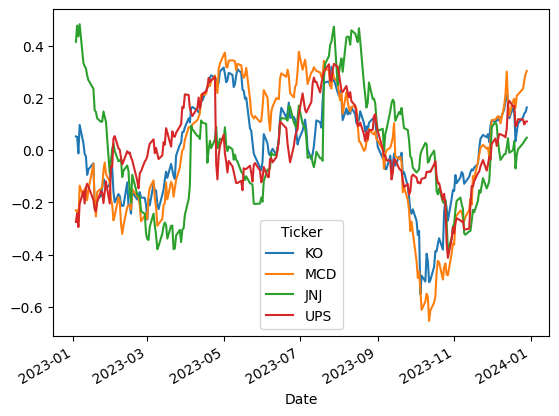

In [465]:
ticks = {
        "KO" : [0.0, 0.0],
        "MCD" : [2, 0.0],

        "UPS" : [-4, 1.0],

        "JNJ" : [7, 4.],   # Johnson & Johnson
        "PG"  : [20., 10.],  # Procter & Gamble

        "XOM" : [100., 100.],   # ExxonMobil
        }

num_assets = len(ticks.keys())

start_date = "2023-01-01"
end_date = "2024-01-01"

data = yf.download(list(ticks.keys()), start=start_date, end=end_date)["Close"]

max = data.max()
min = data.min()
data = (data - min) / (max - min)

for tick in ticks.keys():
    data[tick] = detrend(data[tick])

grid = tc.tensor(list(ticks.values())).float()
ts = tc.arange(len(data.index)).reshape(-1,1).float()
Ys = tc.from_numpy(data.to_numpy()).unsqueeze(-1).float()
print()
print(ts.shape, grid.shape, Ys.shape)

data[["KO", "MCD", "JNJ", "UPS"]].plot()

In [447]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    #energies = 0.5 * (mahalanobis_dist)

    Ws = (Ws / Ws.sum()).squeeze()
    
    return energies.sum()

100%|██████████| 20/20 [00:01<00:00, 11.82it/s]


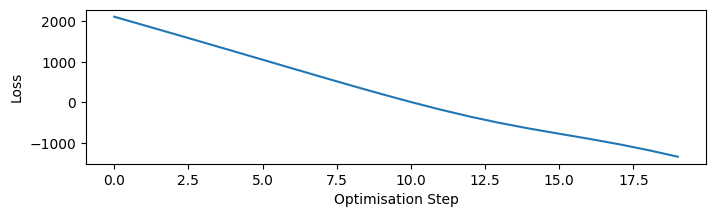

In [456]:
gp = SpatioTemporalRCGP(ts=ts, grid=grid, Ys=Ys, p=1)

losses = []
n_steps = 20
lr = 0.3

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=False)   
    loss = scoring_rule(Ys=Ys, preds=preds_filt, covs=covs_filt, R=R, Ws=Ws_norm)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [457]:
print("Temporal Lengthscale : ", gp.temporal_lengthscale.item())
print("Temporal Magnitude : ", gp.temporal_magnitude.item())
print("Spatial Lengthscale : ", gp.spatial_lengthscale.item())
print("Spatial Magnitude : ", gp.spatial_magnitude.item())
print("Variance (data) : ", gp.var_y.item())

Temporal Lengthscale :  4.570615291595459
Temporal Magnitude :  0.11098821461200714
Spatial Lengthscale :  5.4627509117126465
Spatial Magnitude :  0.11098818480968475
Variance (data) :  0.006067061796784401


In [458]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

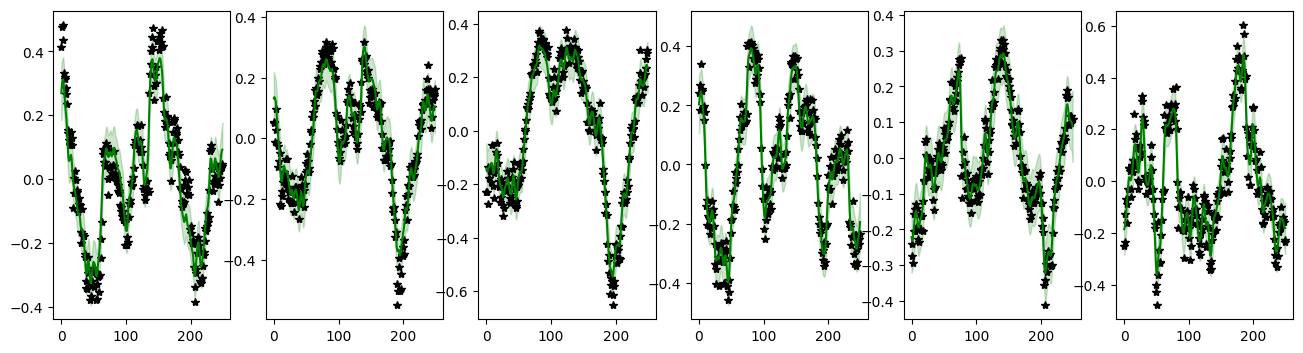

In [459]:
fig, axs = plt.subplots(1, 6, figsize=(16,4))

for i in range(6):
    axs[i].plot(ts, Ys[:, i], 'k*', label="Data")
    axs[i].plot(ts, preds_smooth[:, i], color='green', label="Fit")
    axs[i].fill_between(ts.flatten(), preds_smooth[:, i] - 2 * stds_smooth[:, i], preds_smooth[:, i] + 2 * stds_smooth[:, i], alpha=0.2, color='green')


In [531]:
Ps.shape, ts.shape

(torch.Size([252, 12, 12]), torch.Size([250, 1]))

In [534]:
data.index

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)

[0.12794612 0.14358303 0.16804219 0.17085322 0.19311573 0.19645971]
[0.12794584 0.14358313 0.16804238 0.17085318 0.19311571 0.19645977]
[0.12794597 0.14358304 0.16804239 0.17085316 0.19311567 0.19645978]
[0.12794592 0.1435831  0.16804296 0.17085289 0.19311436 0.19646078]
[0.12796151 0.14358006 0.16814815 0.17078864 0.19291574 0.1966059 ]


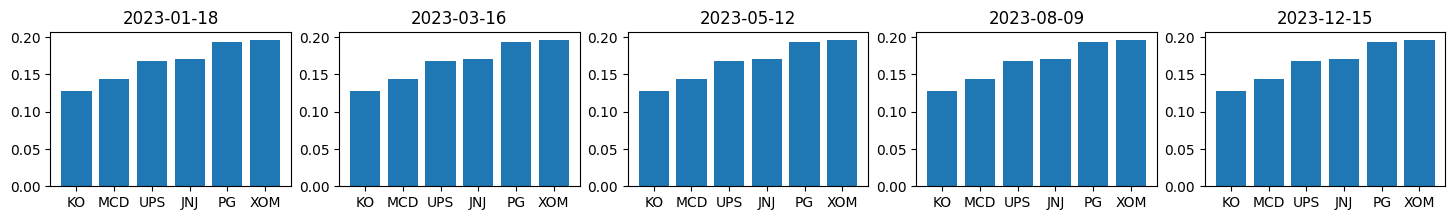

In [598]:
def portfolio_variance(weights, cov_matrix):
    weights = np.exp(weights)
    weights = weights / np.sum(weights)
    return np.dot(weights.T, np.dot(cov_matrix, weights))  # w^T Σ w

#constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Weights sum to 1
#bounds = tuple((0, 1) for _ in range(num_assets))  # No short-selling: 0 <= w_i <= 1

initial_weights = np.ones(num_assets) / num_assets

num_dates = 5
factor = 1e5

fig, axs = plt.subplots(1,num_dates, figsize=(18,2))

for i, idx in enumerate([10, 50, 90, 150, 240]):
    cov_matrix = factor * (gp.H @ Ps[1:-1][idx] @ gp.H.T)
    #cov_matrix[range(num_assets), range(num_assets)] = 1e-3
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                    method='BFGS')
    
    ws = np.exp(result.x)
    ws = ws / np.sum(ws)
    print(ws)

    axs[i].bar(ticks.keys(), ws)
    axs[i].set_title("{}".format(data.index[idx].date()))

[2.58732581e-02 2.67419439e-01 7.91257288e-09 3.87240139e-08
 3.55210261e-01 3.51496995e-01]


<BarContainer object of 6 artists>

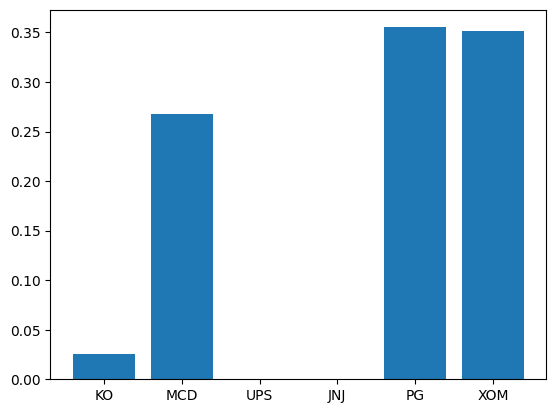

In [604]:
cov_matrix = factor * data.cov().to_numpy()

result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
            method='BFGS')

ws = np.exp(result.x)
ws = ws / ws.sum()
print(ws)

plt.bar(ticks.keys(), ws)
